# Estudo de Caso 2

**Esse Estudo de caso tem como principal intuito a criação de um modelo de Árvore de Decisão para decisão de risco de crédito**

## Imports

In [1]:
import inspect
import os  # paths para os scripts
import sys

sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "data"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "features"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "models"))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), "src", "visualization"))

In [2]:
import context as c  # shotscuts para os paths

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn import metrics, preprocessing
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text

In [4]:
dataset = pd.read_csv(c.DATA_EXTERNAL_FLD / "credito.csv")

## Exploração de Dados

In [5]:
dataset.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

In [7]:
dataset.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [8]:
for col in dataset.columns:
    print(f"a coluna {col} tem os seguintes valores {dataset[col].unique()}")

a coluna checking_balance tem os seguintes valores ['< 0 DM' '1 - 200 DM' 'unknown' '> 200 DM']
a coluna months_loan_duration tem os seguintes valores [ 6 48 12 42 24 36 30 15  9 10  7 60 18 45 11 27  8 54 20 14 33 21 16  4
 47 13 22 39 28  5 26 72 40]
a coluna credit_history tem os seguintes valores ['critical' 'good' 'poor' 'perfect' 'very good']
a coluna purpose tem os seguintes valores ['furniture/appliances' 'education' 'car' 'business' 'renovations' 'car0']
a coluna amount tem os seguintes valores [ 1169  5951  2096  7882  4870  9055  2835  6948  3059  5234  1295  4308
  1567  1199  1403  1282  2424  8072 12579  3430  2134  2647  2241  1804
  2069  1374   426   409  2415  6836  1913  4020  5866  1264  1474  4746
  6110  2100  1225   458  2333  1158  6204  6187  6143  1393  2299  1352
  7228  2073  5965  1262  3378  2225   783  6468  9566  1961  6229  1391
  1537  1953 14421  3181  5190  2171  1007  1819  2394  8133   730  1164
  5954  1977  1526  3965  4771  9436  3832  5943  121

Após algumas análises prévias temos nesse dataset na maioria de suas colunas dados categoricos, como é o caso de:

- "job"
- "housing"
- "saving_balances" 

Também nesse dataset temos algumas colunas onde os valores categoricos estão em faixas representado pelas variáveis, "checking_balance","saving_balances" e "employment_duration"

Neste primeiro momento, não vou transformar as váriaveis categoricas em inteiros, nem realizar um enconding para transformar algumas colunas, isso para eu saber como o modelo lida com os dados nessa forma.

## ETL

Este ETL foi realizado com o LabelEncoder() para transformar os dados categoricos em numericos

In [9]:
categorical_columns = [
    "checking_balance",
    "credit_history",
    "purpose",
    "savings_balance",
    "employment_duration",
    "other_credit",
    "housing",
    "job",
    "phone",
    "default",
]

In [10]:
label_object = {}
for col in categorical_columns:
    labelencoder = preprocessing.LabelEncoder()
    labelencoder.fit(dataset[col])
    dataset[col] = labelencoder.fit_transform(dataset[col])
    label_object[col] = labelencoder

## Separação do Dataset em Treino e Teste

In [11]:
features = [
    "checking_balance",
    "months_loan_duration",
    "credit_history",
    "purpose",
    "amount",
    "savings_balance",
    "employment_duration",
    "percent_of_income",
    "years_at_residence",
    "age",
    "other_credit",
    "housing",
    "existing_loans_count",
    "job",
]

In [12]:
target = "default"

In [13]:
df_treino, df_teste = train_test_split(dataset, test_size=0.3, random_state=101)

x_treino = df_treino[features].copy()
y_treino = df_treino[target].copy()

x_teste = df_teste[features].copy()
y_teste = df_teste[target].copy()

### Grafico para mostrar distribuição da váriavel target nos dataset's de treino e teste

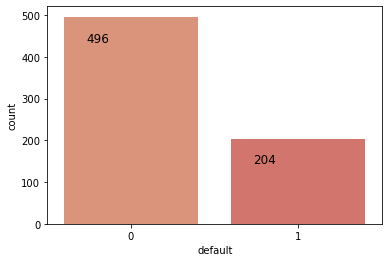

In [14]:
sns.set_palette("flare")
ax = sns.countplot(x="default", data=df_treino)
ax = plt.subplot()
for p in ax.patches:
    ax.annotate(
        f"\n{p.get_height()}",
        (p.get_x() + 0.2, p.get_height()),
        ha="center",
        va="top",
        color="black",
        size=12,
    )
plt.show()

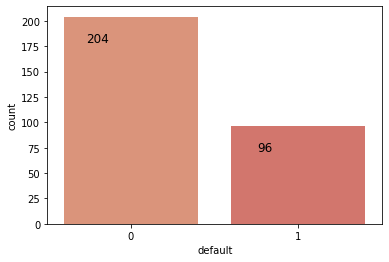

In [15]:
sns.set_palette("flare")
ax = sns.countplot(x="default", data=df_teste)
ax = plt.subplot()
for p in ax.patches:
    ax.annotate(
        f"\n{p.get_height()}",
        (p.get_x() + 0.2, p.get_height()),
        ha="center",
        va="top",
        color="black",
        size=12,
    )
plt.show()

## Construindo o modelo de árvore de classificação

In [16]:
clf = DecisionTreeClassifier()

In [17]:
clf.fit(x_treino, y_treino)

DecisionTreeClassifier()

In [18]:
y_pred = clf.predict(x_teste)

In [19]:
clf.score(x_teste, y_teste)

0.67

In [20]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### Usando GridSearch para melhorar o desempenho do modelo

In [22]:
from sklearn.model_selection import GridSearchCV, KFold

# create a dictionary of all values we want to test
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(3, 15),
    "min_samples_leaf": np.arange(3, 15),
    "min_samples_split": np.arange(3, 15),
    "max_leaf_nodes": np.arange(3, 15),
    "max_features": ["auto", "sqrt", "log2"]
}
# decision tree model
dtree_model = DecisionTreeClassifier()
# use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=5)
# fit model to data
dtree_gscv.fit(x_treino, y_treino)

# Imprimir os melhores hyperparâmetros encontrados
print("Melhores hyperparâmetros: ", dtree_gscv.best_estimator_)

Melhores hyperparâmetros:  DecisionTreeClassifier(max_depth=14, max_features='auto', max_leaf_nodes=13,
                       min_samples_leaf=13, min_samples_split=12)


In [23]:
dtree_gscv = DecisionTreeClassifier(max_depth=14, max_features='auto', max_leaf_nodes=13,
                       min_samples_leaf=13, min_samples_split=12)


In [24]:
dtree_gscv.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=14, max_features='auto', max_leaf_nodes=13,
                       min_samples_leaf=13, min_samples_split=12)

In [25]:
y_pred = dtree_gscv.predict(x_teste)

In [26]:
dtree_gscv.score(x_teste, y_teste)

0.7166666666666667

## Árvore de Decisão

In [27]:
tree_rules = export_text(dtree_gscv, feature_names=features)
print(tree_rules)

|--- savings_balance <= 2.50
|   |--- months_loan_duration <= 47.50
|   |   |--- months_loan_duration <= 11.50
|   |   |   |--- checking_balance <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- checking_balance >  2.50
|   |   |   |   |--- class: 0
|   |   |--- months_loan_duration >  11.50
|   |   |   |--- credit_history <= 1.50
|   |   |   |   |--- purpose <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- purpose >  0.50
|   |   |   |   |   |--- age <= 25.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- age >  25.50
|   |   |   |   |   |   |--- amount <= 8181.00
|   |   |   |   |   |   |   |--- amount <= 1286.50
|   |   |   |   |   |   |   |   |--- checking_balance <= 2.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- checking_balance >  2.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- amount >  1286.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |

## Matriz de Confussão

In [28]:
conf_matrix = confusion_matrix(y_teste, y_pred)
print(conf_matrix)

[[180  24]
 [ 61  35]]


## Curva ROC

In [29]:
def evaluate_model(df_train, df_test, target, model, train_features):

    df_train["Probability"] = model.predict_proba(df_train[train_features])[:, 1]
    df_test["Probability"] = model.predict_proba(df_test[train_features])[:, 1]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    # Plot AUC Curve

    fpr_train, tpr_train, threshold_train = roc_curve(
        df_train[target], df_train["Probability"]
    )
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, threshold_test = roc_curve(
        df_test[target], df_test["Probability"]
    )
    roc_auc_test = auc(fpr_test, tpr_test)
    sns.set(font_scale=1.5)
    title = "Receiver Operating Characteristic (ROC) Curve"
    ax = axes[0]
    ax.plot(
        fpr_train,
        tpr_train,
        color="darkorange",
        label="AUC = {}".format(round(roc_auc_train, 3)),
    )
    ax.plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax.legend(loc="lower right")
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
    ax.set_title("Train")

    ax = axes[1]
    ax.plot(
        fpr_test,
        tpr_test,
        color="darkorange",
        label="AUC = {}".format(round(roc_auc_test, 3)),
    )
    ax.plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax.legend(loc="lower right")
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
    ax.set_title("Validation")

    fig.suptitle(title)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


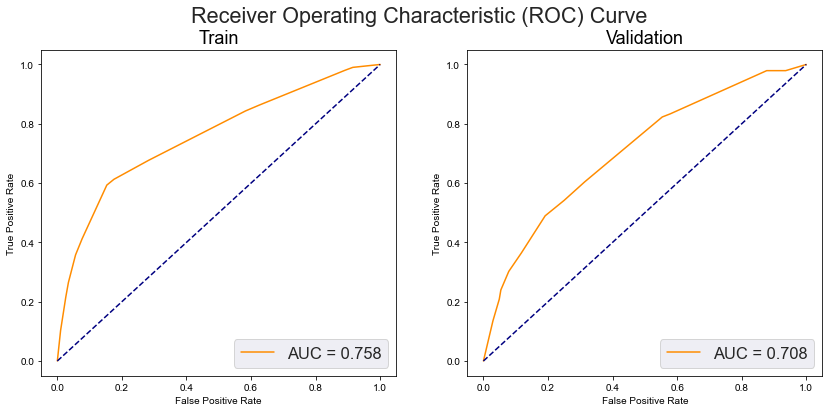

In [30]:
evaluate_model(
    df_train=df_treino,
    df_test=df_teste,
    target=target,
    model=dtree_gscv,
    train_features=features,
)

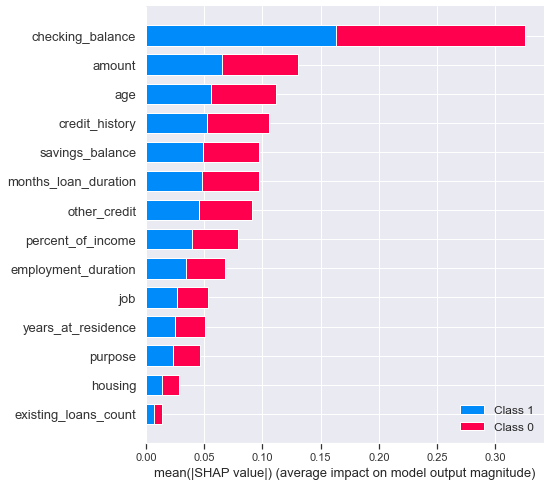

In [31]:
shap_valores = shap.Explainer(clf, x_teste).shap_values(x_teste)
shap.summary_plot(shap_valores, x_teste, plot_type="bar", show=False)